## Wildfire Prediction

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
from catboost import CatBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

### Data Understanding 

In [10]:
df=pd.read_csv(r"C:\Users\Nikhi\Desktop\e698ee94-2-dataset\dataset\train.csv")
print(df.shape)
print(df.columns)
df['year_cat']=df['fire_year'].astype(str)
df.head()

(110, 5)
Index(['id', 'NWCG_REPORTING_UNIT_NAME', 'fire_year', 'Month', 'Frequency'], dtype='object')


,id,NWCG_REPORTING_UNIT_NAME,fire_year,Month,Frequency,year_cat
0,18,Inyo National Forest,1992,5,8,1992
1,54,Inyo National Forest,1992,6,20,1992
2,23,Inyo National Forest,1992,7,18,1992
3,12,Inyo National Forest,1992,8,47,1992
4,106,Inyo National Forest,1992,9,13,1992


Text(0, 0.5, 'Frequency of Wildfires')

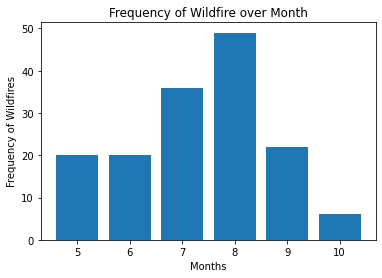

In [45]:
plt.bar(x=df['Month'],height=df['Frequency'])
plt.title("Frequency of Wildfire over Month")
plt.xlabel("Months")
plt.ylabel("Frequency of Wildfires")

In [12]:
year_df=df.groupby(['year_cat'])['Frequency'].mean()

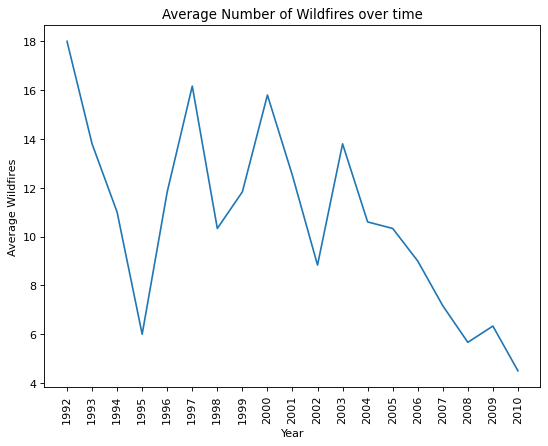

In [13]:
figure(figsize=(8, 6), dpi=80)
plt.title("Average Number of Wildfires over time")
plt.xlabel("Year")
plt.ylabel("Average Wildfires")
plt.xticks(rotation=90)
plt.plot(year_df)

In [14]:
nc = xr.open_dataset('InyoNationalForest.nc')
nc.to_dataframe()
precip=pd.read_csv('precip.csv')
print(precip.columns)
print(precip.shape)

Index(['longitude', 'latitude', 'time', 'tp', 't2m', 'd2m', 'si10', 'swvl1',
       'pev'],
      dtype='object')
(17280, 9)


In [15]:
#Creating variables for month and year 
precip['timed_date']=pd.to_datetime(precip['time'])
type(precip['timed_date'][0])
precip['year']=pd.DatetimeIndex(precip['timed_date']).year
precip['month']=pd.DatetimeIndex(precip['timed_date']).month
precip.head()

,longitude,latitude,time,tp,t2m,d2m,si10,swvl1,pev,timed_date,year,month
0,-110.172997,44.992001,1992-01-01,0.001186,262.52625,259.00754,2.027348,0.294493,-0.000620,1992-01-01,1992,1
1,-110.172997,44.992001,1992-02-01,0.001368,267.23865,262.60654,2.054176,0.295664,-0.001059,1992-02-01,1992,2
2,-110.172997,44.992001,1992-03-01,0.001252,270.91266,265.39194,1.790408,0.276397,-0.001826,1992-03-01,1992,3
3,-110.172997,44.992001,1992-04-01,0.003385,273.33087,267.66733,2.610492,0.337531,-0.002593,1992-04-01,1992,4
4,-110.172997,44.992001,1992-05-01,0.002028,277.08188,270.93970,2.100485,0.410573,-0.003422,1992-05-01,1992,5


### Feature Engineering

In [16]:
#Since the wildfire data is at month level, the aggregation is done with adding different features 
precip_mean=precip.groupby(['year','month'])['tp','t2m','d2m','si10','swvl1','pev'].mean()
precip_max=precip.groupby(['year','month'])['tp','t2m','d2m','si10','swvl1','pev'].max()
precip_min=precip.groupby(['year','month'])['tp','t2m','d2m','si10','swvl1','pev'].min()

<ipython-input-16-4d492f82d863>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  precip_mean=precip.groupby(['year','month'])['tp','t2m','d2m','si10','swvl1','pev'].mean()
<ipython-input-16-4d492f82d863>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  precip_max=precip.groupby(['year','month'])['tp','t2m','d2m','si10','swvl1','pev'].max()
<ipython-input-16-4d492f82d863>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  precip_min=precip.groupby(['year','month'])['tp','t2m','d2m','si10','swvl1','pev'].min()


In [17]:
precip_mean.reset_index(inplace=True)
precip_mean['tp_mean']=precip_mean['tp']
precip_mean['t2m_mean']=precip_mean['t2m']
precip_mean['d2m_mean']=precip_mean['d2m']
precip_mean['si10_mean']=precip_mean['si10']
precip_mean['swvl1_mean']=precip_mean['swvl1']
precip_mean['pev_mean']=precip_mean['pev']
precip_mean=precip_mean.drop(['tp','t2m','d2m','si10','swvl1','pev'],axis=1)


In [18]:
precip_min.reset_index(inplace=True)
precip_min['tp_min']=precip_min['tp']
precip_min['t2m_min']=precip_min['t2m']
precip_min['d2m_min']=precip_min['d2m']
precip_min['si10_min']=precip_min['si10']
precip_min['swvl1_min']=precip_min['swvl1']
precip_min['pev_min']=precip_min['pev']
precip_min=precip_min.drop(['tp','t2m','d2m','si10','swvl1','pev'],axis=1)


In [19]:
precip_max.reset_index(inplace=True)
precip_max['tp_max']=precip_max['tp']
precip_max['t2m_max']=precip_max['t2m']
precip_max['d2m_max']=precip_max['d2m']
precip_max['si10_max']=precip_max['si10']
precip_max['swvl1_max']=precip_max['swvl1']
precip_max['pev_max']=precip_max['pev']
precip_max=precip_max.drop(['tp','t2m','d2m','si10','swvl1','pev'],axis=1)

In [20]:
x1=df.merge(precip_mean,left_on=['fire_year','Month'],right_on=['year','month'],how='inner')
x2=x1.merge(precip_max,left_on=['fire_year','Month'],right_on=['year','month'],how='inner')
fin1=x2.merge(precip_min,left_on=['fire_year','Month'],right_on=['year','month'],how='inner')
print(fin1.shape)
fin2=fin1[['tp_mean', 't2m_mean',
       'd2m_mean', 'si10_mean', 'swvl1_mean', 'pev_mean', 'tp_max', 't2m_max',
       'd2m_max', 'si10_max', 'swvl1_max', 'pev_max', 'month',
       'tp_min', 't2m_min', 'd2m_min', 'si10_min', 'swvl1_min', 'pev_min','Frequency']]
fin2.head(10)

(110, 30)


,tp_mean,t2m_mean,d2m_mean,si10_mean,swvl1_mean,pev_mean,tp_max,t2m_max,d2m_max,si10_max,swvl1_max,pev_max,month,tp_min,t2m_min,d2m_min,si10_min,swvl1_min,pev_min,Frequency
0,0.002561,279.679262,272.281740,2.243884,0.326584,-0.003766,0.004325,286.36142,275.99100,2.616072,0.416825,-0.000823,5,0.001359,275.96765,269.58224,1.834114,0.142984,-0.004830,8
1,0.004028,283.183077,276.339983,1.942733,0.324332,-0.004339,0.007273,289.95337,281.44390,2.695300,0.402318,-0.000939,6,0.001157,278.96710,273.59952,1.511576,0.116860,-0.005638,20
2,0.002641,284.829409,276.217704,2.351191,0.302999,-0.004992,0.005596,290.09180,282.06010,3.006400,0.372302,-0.001309,7,0.001290,281.65527,273.47214,1.688909,0.133540,-0.005919,18
3,0.001342,286.077014,275.046340,2.286422,0.218621,-0.005072,0.002926,291.28992,279.35147,2.820651,0.305685,-0.001343,8,0.000485,282.92044,272.49005,1.707275,0.080965,-0.005883,47
4,0.001179,281.305079,271.068519,2.899905,0.220946,-0.003575,0.002450,287.35100,274.38600,3.595867,0.345280,-0.000789,9,0.000134,277.34305,269.40875,2.364439,0.055790,-0.004523,13
5,0.001302,276.657012,268.361350,2.449540,0.228713,-0.001999,0.001981,281.49805,272.91965,2.997054,0.354369,-0.000445,10,0.000345,272.96260,266.33290,2.009912,0.055819,-0.002704,2
6,0.002842,278.944129,272.577662,2.061219,0.341376,-0.003423,0.004364,286.52927,277.37512,2.566322,0.396393,-0.000783,5,0.001751,275.39020,269.83295,1.678866,0.151019,-0.004553,5
7,0.003330,281.109774,273.702998,2.611852,0.336403,-0.004144,0.005517,287.92910,278.84238,3.090882,0.407859,-0.000918,6,0.002426,277.04056,271.02370,2.164091,0.161389,-0.004822,18
8,0.002409,283.255489,274.661625,2.620428,0.278235,-0.004782,0.004639,289.06024,281.01114,3.470330,0.367017,-0.001136,7,0.000887,279.64792,272.11783,1.842483,0.096585,-0.006121,8
9,0.001928,284.424077,275.817774,2.382543,0.250210,-0.004467,0.003685,290.37488,279.81088,2.941167,0.350832,-0.001068,8,0.000682,280.91183,273.64468,1.878377,0.081647,-0.005350,35


Text(0.5, 1.0, 'Correlation Heatmap')

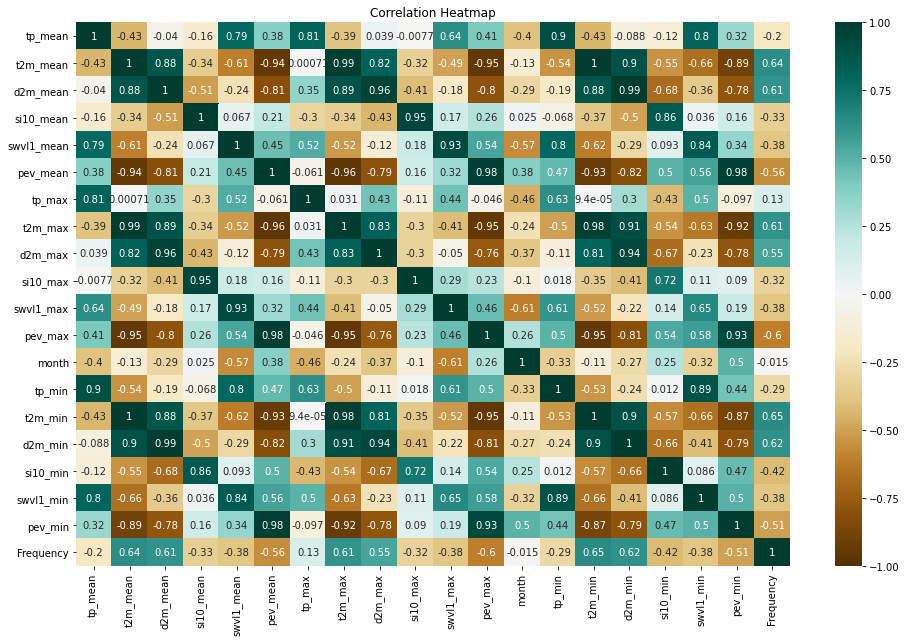

In [25]:
plt.figure(figsize=(16,10))
mask=np.triu(np.ones_like(fin2.corr()))
heatmap=sns.heatmap(fin2.corr(),vmin=-1,vmax=1,annot=True,cmap="BrBG")
heatmap.set_title("Correlation Heatmap")

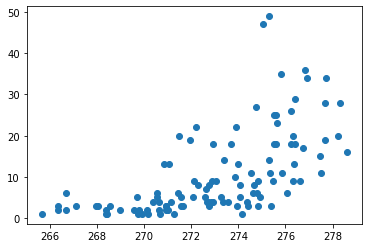

In [26]:
plt.scatter(fin1['d2m_mean'],fin1['Frequency'])
plt.show()

### Model Development 

In [27]:
input_list=['tp_mean', 't2m_mean',
       'd2m_mean', 'si10_mean', 'swvl1_mean', 'pev_mean', 'tp_max', 't2m_max',
       'd2m_max', 'si10_max', 'swvl1_max', 'pev_max', 'month',
       'tp_min', 't2m_min', 'd2m_min', 'si10_min', 'swvl1_min', 'pev_min']

In [28]:
x_train,x_test,y_train,y_test=train_test_split(fin2[input_list],fin2['Frequency'],test_size=0.2, random_state=100)

## Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
log=LinearRegression()
log.fit(x_train,y_train)
Yhat_log=log.predict(x_test)
from sklearn.metrics import r2_score,mean_squared_error
print(r2_score(y_test,Yhat_log))
print(mean_squared_error(y_test,Yhat_log))

0.26033216214208277
49.8022634299872


In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(len(x_train.columns))]
print(vif_data)

       feature           VIF
0      tp_mean  1.800116e+02
1     t2m_mean  6.034771e+06
2     d2m_mean  3.328301e+06
3    si10_mean  6.984770e+03
4   swvl1_mean  1.483829e+03
5     pev_mean  4.683160e+03
6       tp_max  1.167827e+02
7      t2m_max  9.042395e+05
8      d2m_max  4.175740e+05
9     si10_max  2.473374e+03
10   swvl1_max  1.552246e+03
11     pev_max  1.878871e+03
12       month  3.873972e+02
13      tp_min  4.193754e+01
14     t2m_min  3.567780e+06
15     d2m_min  1.883773e+06
16    si10_min  1.892139e+03
17   swvl1_min  5.354291e+01
18     pev_min  2.462403e+03


#### Removing the top few variables with Highest VIF

In [31]:
input_list2=[x for x in input_list if x not in ['t2m_mean','t2m_max','d2m_mean']]
print(input_list2)

['tp_mean', 'si10_mean', 'swvl1_mean', 'pev_mean', 'tp_max', 'd2m_max', 'si10_max', 'swvl1_max', 'pev_max', 'month', 'tp_min', 't2m_min', 'd2m_min', 'si10_min', 'swvl1_min', 'pev_min']


In [32]:
x_train2=x_train[input_list2]
x_test2=x_test[input_list2]
print(type(x_train2))
x_train2.head()

<class 'pandas.core.frame.DataFrame'>


,tp_mean,si10_mean,swvl1_mean,pev_mean,tp_max,d2m_max,si10_max,swvl1_max,pev_max,month,tp_min,t2m_min,d2m_min,si10_min,swvl1_min,pev_min
46,0.000622,2.717035,0.226948,-0.002288,0.001530,271.31870,3.170342,0.332678,-0.000580,10,0.000157,273.79870,263.92380,2.257314,0.080039,-0.002863
11,0.001695,2.423657,0.326585,-0.004032,0.003339,276.28330,3.045084,0.414733,-0.000824,5,0.000905,276.18560,269.85193,1.907251,0.104864,-0.005282
72,0.002160,2.229762,0.239141,-0.004735,0.003293,278.28630,2.674005,0.316959,-0.001190,8,0.000461,281.79242,273.73910,1.838810,0.055412,-0.005570
90,0.001624,2.565629,0.229682,-0.003649,0.002348,275.59800,3.063496,0.320600,-0.000896,9,0.000434,278.75730,270.69080,2.176412,0.054887,-0.004190
89,0.001501,2.441614,0.217317,-0.005452,0.002714,279.07547,2.942190,0.315357,-0.001401,8,0.000342,284.22507,274.31598,1.969555,0.048345,-0.006204


In [33]:
log=LinearRegression()
log.fit(x_train2,y_train)
Yhat_log=log.predict(x_test2)
from sklearn.metrics import r2_score,mean_squared_error
print(r2_score(y_test,Yhat_log))
print(mean_squared_error(y_test,Yhat_log))

0.3821894767238605
41.597539943228995


In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train2.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train2.values, i) for i in range(len(x_train2.columns))]
print(vif_data)

       feature            VIF
0      tp_mean     161.475709
1    si10_mean    5888.841685
2   swvl1_mean    1207.577009
3     pev_mean    3880.955351
4       tp_max     107.666335
5      d2m_max  246058.867953
6     si10_max    2346.099419
7    swvl1_max    1316.977446
8      pev_max    1418.803153
9        month     318.878912
10      tp_min      39.258215
11     t2m_min  319828.473093
12     d2m_min  233807.151975
13    si10_min    1597.925526
14   swvl1_min      49.726599
15     pev_min    2280.380632


#### Removing variables with highest VIF

In [35]:
input_list3=[x for x in input_list2 if x not in ['d2m_max','d2m_min']]
x_train3=x_train2[input_list3]
x_test3=x_test2[input_list3]

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train3.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train3.values, i) for i in range(len(x_train3.columns))]
print(vif_data)

       feature          VIF
0      tp_mean   155.220326
1    si10_mean  5748.029100
2   swvl1_mean   830.267023
3     pev_mean  3643.236265
4       tp_max    91.313056
5     si10_max  2321.803445
6    swvl1_max  1247.322120
7      pev_max  1115.718308
8        month   251.022189
9       tp_min    38.433390
10     t2m_min  2071.532102
11    si10_min  1371.702921
12   swvl1_min    43.982988
13     pev_min  2273.130959


#### Further removing few more variables 

In [37]:
input_list4=[x for x in input_list3 if x not in ['si10_mean','pev_mean','si10_max','swlv1_max','t2m_min','swvl1_max','pev_min','si10_min','tp_mean','swvl1_mean','swvl1_min','tp_max']]
x_train4=x_train3[input_list4]
x_test4=x_test3[input_list4]

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train4.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train4.values, i) for i in range(len(x_train4.columns))]
print(vif_data)

   feature       VIF
0  pev_max  4.986742
1    month  6.696208
2   tp_min  2.378369


In [44]:
log=LinearRegression()
log.fit(x_train4,y_train)
Yhat_log=log.predict(x_test4)
from sklearn.metrics import r2_score,mean_squared_error
print(r2_score(y_test,Yhat_log))
print(mean_squared_error(y_test,Yhat_log))
print(log.coef_)

0.3855540330915568
41.37100241655443
[-2.07891578e+04  1.69765688e+00  2.61966794e+03]


## CAT Boost algorithm

In [40]:
cat=CatBoostRegressor(loss_function='RMSE')
cat.fit(x_train,y_train)
yhat_test=cat.predict(x_test)
print(r2_score(y_test,yhat_test))
print(mean_squared_error(y_test,yhat_test))


Learning rate set to 0.027887
0:	learn: 10.5150550	total: 148ms	remaining: 2m 28s
1:	learn: 10.3941662	total: 150ms	remaining: 1m 14s
2:	learn: 10.2722793	total: 151ms	remaining: 50.1s
3:	learn: 10.1592793	total: 152ms	remaining: 37.8s
4:	learn: 10.0657770	total: 153ms	remaining: 30.4s
5:	learn: 9.9670977	total: 154ms	remaining: 25.5s
6:	learn: 9.9040958	total: 155ms	remaining: 22s
7:	learn: 9.7915483	total: 156ms	remaining: 19.3s
8:	learn: 9.7158743	total: 157ms	remaining: 17.3s
9:	learn: 9.6263941	total: 158ms	remaining: 15.6s
10:	learn: 9.5321562	total: 159ms	remaining: 14.3s
11:	learn: 9.4415562	total: 160ms	remaining: 13.1s
12:	learn: 9.3466829	total: 160ms	remaining: 12.2s
13:	learn: 9.2597283	total: 161ms	remaining: 11.4s
14:	learn: 9.1643613	total: 162ms	remaining: 10.7s
15:	learn: 9.0837477	total: 163ms	remaining: 10s
16:	learn: 8.9949701	total: 164ms	remaining: 9.49s
17:	learn: 8.8932230	total: 165ms	remaining: 9.01s
18:	learn: 8.8167469	total: 166ms	remaining: 8.58s
19:	lear

223:	learn: 3.0027825	total: 347ms	remaining: 1.2s
224:	learn: 2.9948363	total: 348ms	remaining: 1.2s
225:	learn: 2.9819709	total: 349ms	remaining: 1.19s
226:	learn: 2.9717876	total: 350ms	remaining: 1.19s
227:	learn: 2.9594768	total: 350ms	remaining: 1.19s
228:	learn: 2.9522099	total: 351ms	remaining: 1.18s
229:	learn: 2.9417622	total: 352ms	remaining: 1.18s
230:	learn: 2.9345875	total: 353ms	remaining: 1.17s
231:	learn: 2.9199290	total: 354ms	remaining: 1.17s
232:	learn: 2.9099728	total: 354ms	remaining: 1.17s
233:	learn: 2.9017750	total: 355ms	remaining: 1.16s
234:	learn: 2.8870770	total: 356ms	remaining: 1.16s
235:	learn: 2.8846145	total: 357ms	remaining: 1.16s
236:	learn: 2.8709787	total: 358ms	remaining: 1.15s
237:	learn: 2.8634358	total: 359ms	remaining: 1.15s
238:	learn: 2.8585680	total: 360ms	remaining: 1.15s
239:	learn: 2.8468550	total: 361ms	remaining: 1.14s
240:	learn: 2.8271945	total: 363ms	remaining: 1.14s
241:	learn: 2.8206835	total: 364ms	remaining: 1.14s
242:	learn: 2.

428:	learn: 1.3729562	total: 518ms	remaining: 690ms
429:	learn: 1.3709973	total: 519ms	remaining: 688ms
430:	learn: 1.3655304	total: 520ms	remaining: 686ms
431:	learn: 1.3584941	total: 521ms	remaining: 685ms
432:	learn: 1.3531576	total: 521ms	remaining: 683ms
433:	learn: 1.3464057	total: 522ms	remaining: 681ms
434:	learn: 1.3411680	total: 523ms	remaining: 679ms
435:	learn: 1.3353923	total: 524ms	remaining: 678ms
436:	learn: 1.3324704	total: 525ms	remaining: 676ms
437:	learn: 1.3217339	total: 526ms	remaining: 674ms
438:	learn: 1.3151364	total: 526ms	remaining: 673ms
439:	learn: 1.3068649	total: 527ms	remaining: 671ms
440:	learn: 1.2978284	total: 528ms	remaining: 669ms
441:	learn: 1.2897421	total: 529ms	remaining: 668ms
442:	learn: 1.2809661	total: 530ms	remaining: 666ms
443:	learn: 1.2729359	total: 531ms	remaining: 665ms
444:	learn: 1.2662890	total: 532ms	remaining: 663ms
445:	learn: 1.2612216	total: 533ms	remaining: 662ms
446:	learn: 1.2562924	total: 534ms	remaining: 660ms
447:	learn: 

644:	learn: 0.5791996	total: 691ms	remaining: 380ms
645:	learn: 0.5782217	total: 692ms	remaining: 379ms
646:	learn: 0.5746215	total: 693ms	remaining: 378ms
647:	learn: 0.5731478	total: 694ms	remaining: 377ms
648:	learn: 0.5709910	total: 694ms	remaining: 376ms
649:	learn: 0.5698073	total: 695ms	remaining: 374ms
650:	learn: 0.5689071	total: 696ms	remaining: 373ms
651:	learn: 0.5659447	total: 697ms	remaining: 372ms
652:	learn: 0.5625637	total: 698ms	remaining: 371ms
653:	learn: 0.5599467	total: 698ms	remaining: 369ms
654:	learn: 0.5571495	total: 699ms	remaining: 368ms
655:	learn: 0.5562628	total: 700ms	remaining: 367ms
656:	learn: 0.5539862	total: 701ms	remaining: 366ms
657:	learn: 0.5525898	total: 702ms	remaining: 365ms
658:	learn: 0.5512224	total: 703ms	remaining: 364ms
659:	learn: 0.5501040	total: 704ms	remaining: 363ms
660:	learn: 0.5469755	total: 705ms	remaining: 361ms
661:	learn: 0.5456404	total: 705ms	remaining: 360ms
662:	learn: 0.5443329	total: 706ms	remaining: 359ms
663:	learn: 

863:	learn: 0.2705446	total: 863ms	remaining: 136ms
864:	learn: 0.2695076	total: 864ms	remaining: 135ms
865:	learn: 0.2684762	total: 865ms	remaining: 134ms
866:	learn: 0.2672699	total: 866ms	remaining: 133ms
867:	learn: 0.2661531	total: 866ms	remaining: 132ms
868:	learn: 0.2650796	total: 867ms	remaining: 131ms
869:	learn: 0.2643381	total: 868ms	remaining: 130ms
870:	learn: 0.2633324	total: 869ms	remaining: 129ms
871:	learn: 0.2620362	total: 870ms	remaining: 128ms
872:	learn: 0.2611810	total: 871ms	remaining: 127ms
873:	learn: 0.2601620	total: 871ms	remaining: 126ms
874:	learn: 0.2596586	total: 872ms	remaining: 125ms
875:	learn: 0.2593589	total: 874ms	remaining: 124ms
876:	learn: 0.2583231	total: 875ms	remaining: 123ms
877:	learn: 0.2573672	total: 876ms	remaining: 122ms
878:	learn: 0.2564246	total: 877ms	remaining: 121ms
879:	learn: 0.2554950	total: 878ms	remaining: 120ms
880:	learn: 0.2545004	total: 878ms	remaining: 119ms
881:	learn: 0.2542081	total: 879ms	remaining: 118ms
882:	learn: 

## Random Forest Regression

In [41]:
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
Yhat_rf=rf.predict(x_test)
print(r2_score(y_test,Yhat_rf))
print(mean_squared_error(y_test,Yhat_rf))

0.22019120535166314
52.504977272727274


In [42]:
rf.feature_importances_

array([0.02301813, 0.0269301 , 0.15133398, 0.0367365 , 0.03581662,
       0.01146431, 0.02777988, 0.04523743, 0.02388724, 0.01549676,
       0.02720814, 0.01630384, 0.00360429, 0.03198028, 0.06511443,
       0.37129378, 0.04041726, 0.02609649, 0.02028055])

# Thank you!